# Megaman 3 vs Megaman 4 classifier

### Some background for this project

I'm Machine Learning and Deep Learning enthusiast and I love to tinker around with data and code. I decided to start this classifier project because I wanted to see how videos can be manipulated and cut in to the single frames in order analyse data

I loved playing NES games as a kid and Megaman series has a special place in my heart. I always wondered as a kid when I visited my older family members and I had troubles recognizing is that Megaman 3 or Megaman 4 that they were playing

And that is how I got this project started. I wanted to see if I can find a way to separate those two games (for starter, might expand this to multiple games later) based on images from gameplay

So buckle up, here we go!

In [10]:
# Loading libraries ----

# misc
import os
import shutil
from random import sample, randint, shuffle
import math
import numpy as np
import pandas as pd
from skimage.segmentation import mark_boundaries

# sci-kit learn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# youtube
from pytube import YouTube

# image operation
import cv2
from PIL import Image

# tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# keras 
# import keras
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# from keras.applications import inception_v3 as inc_net

# lime
import lime
from lime import lime_image

print('Notebook run using Tensorflow:', tf.__version__)

Notebook run using Tensorflow: 2.1.0


So here we see that I'm using Tensorflow 2.1.0 to buid my Neural Network. And yes, I decided to with Convolutional Neural Network implemention eventhough I just could have used more traditional ML methods such as Logistic regression, etc. But this a good practice for me so I'm going to stick with Tensorflow and CNN

I recently updated my PC (because my SSD-drive decided to expire his contract) so that I'm running dual-boot with Ubuntu 18.04 and Windows 10 (I had to keep Windows in order to play games). I had quite a lot issues installing necessary drivers for doing Machine Learning with GPU so here I'm just going to make sure that my Jupyter Notebook is ran using GPU

In [2]:
# make sure we are running this on GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13117061205771107239
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3090283820146751541
physical_device_desc: "device: XLA_CPU device"
]


Great! Now you guys are able to see that I have RTX 2080 in use (I like this GPU so much!). Using this GPU makes running the CNN so much faster

Now let's make some functions that help us preprocess and view data along the way

In [9]:
def scrape_frames(video_name, dest_path, every_x_frame, n_images, skip_seconds):
    # function for scraping frames from videos
    vidcap = cv2.VideoCapture(video_name)
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(vidcap.get(cv2.CAP_PROP_FPS))
    every_x_frame = math.floor((total_frames - skip_seconds * fps) / n_images) - 1

    success,image = vidcap.read()
    frame_count = 0
    img_count = 0
    
    while success: 
        success,image = vidcap.read() #success might be false and image might be None
        
        if frame_count > (skip_seconds * 30):
            # break if the video ended
            if not success:
                break

            # action on every x-th frame 
            if (frame_count % every_x_frame == 0):
                cv2.imwrite(dest_path + "_" + str(img_count) + '.jpg', image)   
                img_count += 1
                if (round(img_count / n_images, 2) * 100 % 10 == 0): 
                    print("Completed:", round(img_count / n_images, 2), "done.", end="\r")

            if img_count == n_images:
                break   
            
        frame_count += 1
        
def move_random_files(path_from, path_to, n):
    # function for moving random files from one directory to another (used for creating train and test set)
    files = os.listdir(path_from)
    files.sort()
    files = files[1:] #omiting .DS_Store

    for i in sample(range(0, len(files)-1), n):
        f = files[i]
        src = path_from + f
        dst = path_to + f
        shutil.move(src, dst)
        
def preview_random_image(path):
    # function for previewing a random image from a given directory
    files = os.listdir(path)
    files.sort()
    img_name = files[randint(1, len(files) - 1)]
    img_preview_name = path + img_name
    image = Image.open(img_preview_name)
    plt.imshow(image)
    plt.title(img_name)
    plt.show()
    width, height = image.size
    print ("Dimensions:", image.size, "Total pixels:", width * height)
    
def pretty_cm(y_pred, y_truth, labels):
    # pretty implementation of a confusion matrix
    cm = metrics.confusion_matrix(y_truth, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'BuGn_r')
    # labels, title and ticks
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('Actual label')
    ax.set_title('Accuracy: {0}'.format(metrics.accuracy_score(y_truth, y_pred)), size = 15) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

def show_image(image):
    # function for viewing an image
    fig = plt.figure(figsize = (5, 25))
    ax = fig.add_subplot(111)
    ax.imshow(image, interpolation='none')
    plt.show()

def transform_image(path, size):
    # function for transforming images into a format supported by CNN
    x = load_img(path, target_size=(size[0], size[1]))
    x = img_to_array(x) / 255
    x = np.expand_dims(x, axis=0)
    return (x)

def evaluation_indices(y_pred, y_test):
    # function for getting correctly and incorrectly classified indices
    index = 0
    correctly_classified_indices = []
    misclassified_indices = []
    for label, predict in zip(y_test, y_pred):
        if label != predict: 
            misclassified_indices.append(index)
        else:
            correctly_classified_indices.append(index)
        index +=1
    return (correctly_classified_indices, misclassified_indices)

## Download videos

For downloading videos I use this awesome library called pytube

In [13]:
megaman3_video = YouTube('https://www.youtube.com/watch?v=3U0taIY0Jo8')

Let's see what kind of videos are available for above link in Youtube. We filter videos so that their format is mp4

In [14]:
print('Title:', megaman3_video.title, '---')
stream = megaman3_video.streams.filter(file_extension = 'mp4').all()
for i in stream:
    print(i)

Title: NES Longplay Mega Man 3 ---
<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2">
<Stream: itag="135" mime_type="video/mp4" res="480p" fps="30fps" vcodec="avc1.4d401e">
<Stream: itag="134" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.4d4015">
<Stream: itag="133" mime_type="video/mp4" res="240p" fps="30fps" vcodec="avc1.4d400c">
<Stream: itag="160" mime_type="video/mp4" res="144p" fps="30fps" vcodec="avc1.4d400b">
<Stream: itag="140" mime_type="audio/mp4" abr="128kbps" acodec="mp4a.40.2">


And now we download the specified video from above list. I'm taking the first one which has itag="18"

In [15]:
# download the video
megaman3_video.streams.get_by_itag(18).download()

'/home/ville/Documents/Data_Science/megaman_classifier_cnn/NES Longplay Mega Man 3.mp4'

#### And now same process for Megaman 4 video

In [16]:
megaman4_video = YouTube('https://www.youtube.com/watch?v=vlBYMTGfWMs&t=1s')

In [17]:
print('Title:', megaman4_video.title, '---')
stream = megaman4_video.streams.filter(file_extension = 'mp4').all()
for i in stream:
    print(i)

Title: NES Longplay Mega Man 4 ---
<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2">
<Stream: itag="135" mime_type="video/mp4" res="480p" fps="30fps" vcodec="avc1.4d401e">
<Stream: itag="134" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.4d4015">
<Stream: itag="133" mime_type="video/mp4" res="240p" fps="30fps" vcodec="avc1.4d400c">
<Stream: itag="160" mime_type="video/mp4" res="144p" fps="30fps" vcodec="avc1.4d400b">
<Stream: itag="140" mime_type="audio/mp4" abr="128kbps" acodec="mp4a.40.2">


In [18]:
megaman4_video.streams.get_by_itag(18).download()

'/home/ville/Documents/Data_Science/megaman_classifier_cnn/NES Longplay Mega Man 4.mp4'

## Cut frames from YouTube Video

We will use function we created earlier to cut the video to frames. We want to get 5000 images and cut every 50th frame. We move all cut frames a.k.a pictures to our predefined training_set folder

In [11]:
! mkdir -p training_set/megaman3/megaman3

In [12]:
# Megaman3
scrape_frames('NES Longplay Mega Man 3.mp4',
             'training_set/megaman3/megaman3',
             every_x_frame = 50,
             n_images = 5000,
             skip_seconds = 60)

In [13]:
! mkdir -p training_set/megaman4/megaman4

In [14]:
# Megaman4
scrape_frames('NES Longplay Mega Man 4.mp4',
             'training_set/megaman4/megaman4',
             every_x_frame = 50,
             n_images = 5000,
             skip_seconds = 60)

## Data preprocessing

### Create training and test sets

We use move_random_files created earlier to create our test_sets. We use 20% of our data as test set (n=1000) and rest 80% (n=4000) is used as training data. We do this by moving 1000 random files from training_set folder to test_set folders:

In [16]:
! mkdir -p test_set/megaman3/

In [17]:
move_random_files(path_from = 'training_set/megaman3/',
                 path_to = 'test_set/megaman3/',
                 n = 1000)

In [18]:
! mkdir -p test_set/megaman4/

In [19]:
move_random_files(path_from = 'training_set/megaman4/',
                 path_to = 'test_set/megaman4/',
                 n = 1000)

### Preview images

Let's take a look at random image in Megaman 3 training_set folder:

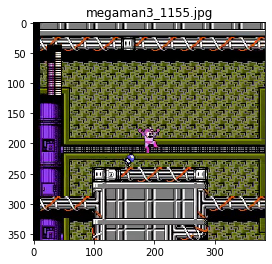

Dimensions: (384, 360) Total pixels: 138240


In [4]:
preview_random_image('training_set/megaman3/')

And the same for Megaman 4:

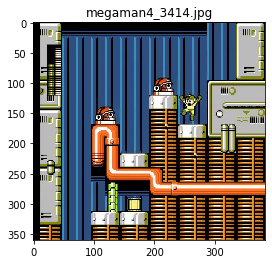

Dimensions: (384, 360) Total pixels: 138240


In [5]:
preview_random_image('training_set/megaman4/')

Here we can see the confusion I had as a kid. Those images look pretty much the same for me! 

#### Compare openCV and Keras rescaling of image:

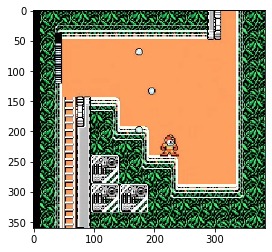

In [6]:
im = cv2.imread('training_set/megaman3/megaman3_1.jpg')
plt.imshow(im)

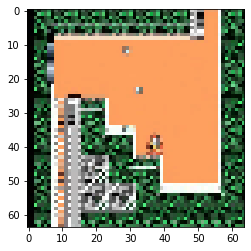

In [7]:
im_cv = cv2.resize(im, (64, 64))
plt.imshow(im_cv)

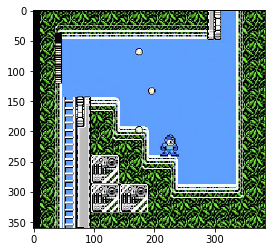

In [11]:
im = load_img('training_set/megaman3/megaman3_1.jpg')
plt.imshow(im)

## Prepare training and test sets

In [22]:
batch_size = 200

In [23]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = False)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('training_set',
                                                target_size = (64, 64),
                                                batch_size = batch_size,
                                                class_mode = 'binary')

test_set = test_datagen.flow_from_directory('test_set',
                                           target_size = (64, 64),
                                            batch_size = batch_size,
                                            class_mode = 'binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [24]:
# Check classes for future reference
labels_index = {0 : 'megaman3', 1 : 'megaman4'}
training_set.class_indices

{'megaman3': 0, 'megaman4': 1}

### Preview transformations

In [28]:
! mkdir preview

In [25]:
files = os.listdir('training_set/megaman3/')
img_name = files[randint(0, len(files)-1)]

img = load_img('training_set/megaman3/' + img_name)

x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in train_datagen.flow(x, batch_size=batch_size,
                               save_to_dir='preview', save_prefix='megaman3', save_format='jpeg'):
    i += 1
    if i > 20:
        break

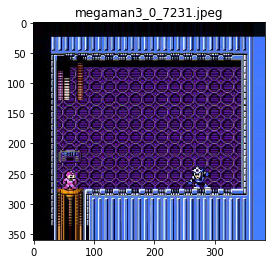

Dimensions: (384, 360) Total pixels: 138240


In [26]:
preview_random_image('preview/')

## Convolutional Neural Network

In [27]:
# TensorFlow 2 CNN implementation
cnn_classifier = models.Sequential()

# 1st conv. layer
cnn_classifier.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(64, 64, 3)))
cnn_classifier.add(layers.MaxPooling2D(2,2))

# 2nd conv. layer
cnn_classifier.add(layers.Conv2D(32,(3, 3), activation='relu'))
cnn_classifier.add(layers.MaxPooling2D((2, 2)))

# 3rd conv.layer
cnn_classifier.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_classifier.add(layers.MaxPooling2D((2, 2)))

# flattening
cnn_classifier.add(layers.Flatten())

# Full connection
cnn_classifier.add(layers.Dense(units=64, activation='relu'))
cnn_classifier.add(layers.Dropout(0.5))
cnn_classifier.add(layers.Dense(units=1, activation='sigmoid'))

cnn_classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)             

In [31]:
# Old Keras CNN
cnn_classifier = Sequential()

# 1st conv. layer
cnn_classifier.add(Conv2D(32, (3,3), input_shape = (64, 64, 3), activation = 'relu'))
cnn_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd conv. layer
cnn_classifier.add(Conv2D(32, (3, 3), activation = 'relu')) # No need to specify input shape 
cnn_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# 3rd conv. layer
cnn_classifier.add(Conv2D(64, (3, 3), activation = 'relu')) # No need to specify input shape 
cnn_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# flattening
cnn_classifier.add(Flatten())

# Full connection
cnn_classifier.add(Dense(units = 64, activation = 'relu'))
cnn_classifier.add(Dropout(0.5)) # Pretty aggressive
cnn_classifier.add(Dense(units = 1, activation = 'sigmoid'))

cnn_classifier.summary()

AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

In [28]:
# Compile CNN
cnn_classifier.compile(optimizer = 'adam',
                      loss = 'binary_crossentropy',
                      metrics = ['accuracy'])

In [35]:
# make sure we are running this on GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12080668992633445454
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9048180130325227680
physical_device_desc: "device: XLA_CPU device"
]


In [30]:
# Old Keras implementation
cnn_classifier.fit(training_set,
                            steps_per_epoch = len(training_set) // batch_size,
                            epochs = 10,
                            validation_data = test_set,
                            validation_steps = len(test_set) // batch_size)

W0218 14:52:22.715139 4611063232 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0218 14:52:23.308292 4611063232 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 40 steps, validate for 10 steps
Epoch 1/10
40/40 [==============================] - 49s 1s/step - loss: 0.6795 - accuracy: 0.5621 - val_loss: 0.6256 - val_accuracy: 0.6175
Epoch 2/10
40/40 [==============================] - 40s 1000ms/step - loss: 0.5618 - accuracy: 0.7064 - val_loss: 0.4497 - val_accuracy: 0.7670
Epoch 3/10
40/40 [==============================] - 41s 1s/step - loss: 0.4326 - accuracy: 0.7984 - val_loss: 0.3370 - val_accuracy: 0.8620
Epoch 4/10
40/40 [==============================] - 46s 1s/step - loss: 0.3350 - accuracy: 0.8562 - val_loss: 0.2506 - val_accuracy: 0.8820
Epoch 5/10
40/40 [==============================] - 42s 1s/step - loss: 0.2732 - accuracy: 0.8884 - val_loss: 0.2235 - val_accuracy: 0.9025
Epoch 6/10
40/40 [==============================] - 39s 970ms/step - loss: 0.2198 - accuracy: 0.9114 - val_loss: 0.1948 - val_accuracy: 0.9175
Epoch 7/10
40/40 [==============================] - 40s 1s/step - loss: 0.2097 - accuracy: 0.9135 - val_loss: 0

In [31]:
# save model and weights
#cnn_classifier.save_weights('megaman3_vs_megaman4_weights_dropout.h5')
#cnn_classifier.save('megaman3_vs_megaman4_model_dropout.h5')
cnn_classifier.save('megaman_classifier.h5')

In [32]:
# load the model
# cnn_classifier = keras.models.load_model('megaman3_vs_megaman4_model_dropout.h5')
cnn_classifier = tf.keras.models.load_model('megaman_classifier.h5')

## Evaluate results

In [33]:
size = (64, 64)
X_eval = list()
y_eval = list()

# megaman3
files = os.listdir('test_set/megaman3')
files.sort()

for i in range(0, len(files) - 1):
    X_eval.append(transform_image('test_set/megaman3/' + files[i + 1], size))
    y_eval.append(0)
    
# megaman4
files = os.listdir('test_set/megaman4')
files.sort()

for i in range(0, len(files) - 1):
    X_eval.append(transform_image('test_set/megaman4/' + files[i + 1], size))
    y_eval.append(1)
    
# stack arrays
X_eval = np.vstack(X_eval)

In [34]:
cnn_pred = cnn_classifier.predict_classes(X_eval, batch_size = 32)

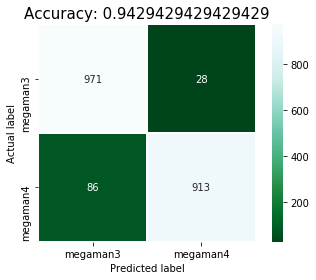

In [35]:
pretty_cm(cnn_pred, y_eval, ['megaman3', 'megaman4'])

In [36]:
correctly_classified_indices, misclassified_indices = evaluation_indices(cnn_pred, y_eval)

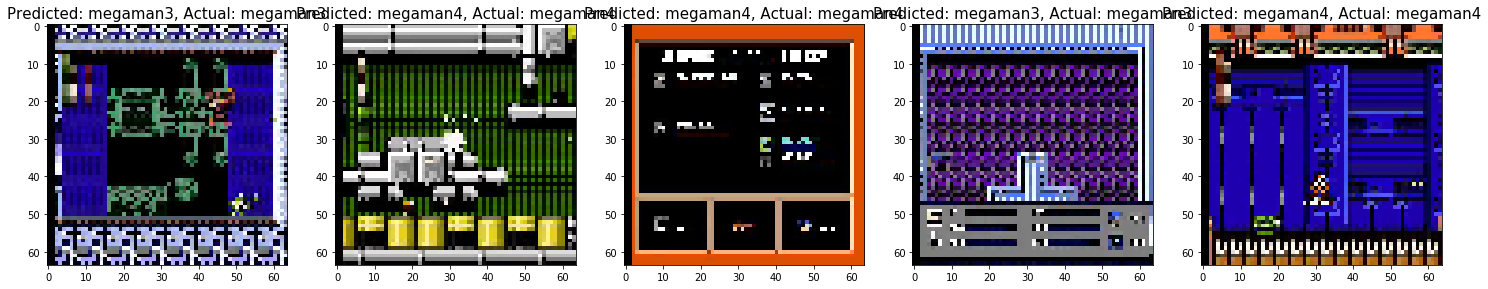

In [37]:
plt.figure(figsize=(25,5))
shuffle(correctly_classified_indices)
for plot_index, good_index in enumerate(correctly_classified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    plt.imshow(X_eval[good_index])
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[cnn_pred[good_index][0]], 
                                                 labels_index[y_eval[good_index]]), fontsize = 15)

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


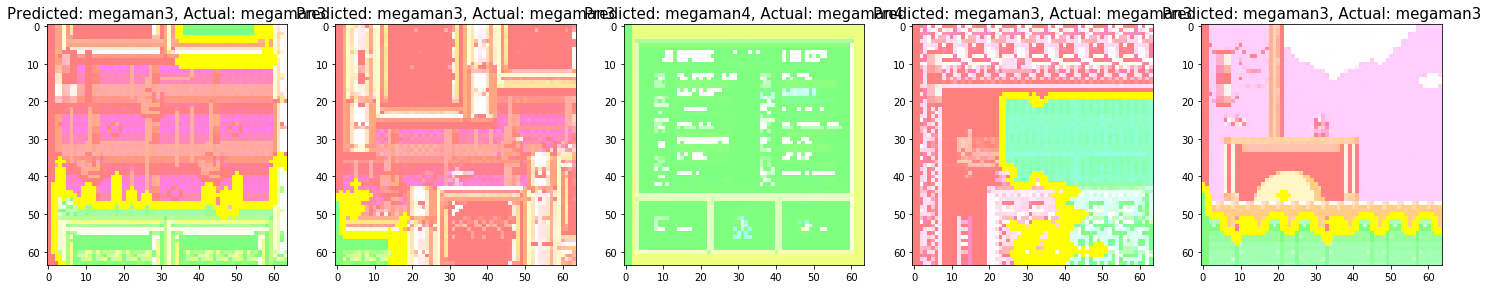

In [38]:
plt.figure(figsize=(25,5))
shuffle(correctly_classified_indices)
for plot_index, good_index in enumerate(correctly_classified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(X_eval[good_index], cnn_classifier.predict_classes, top_labels=2, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=10, hide_rest=False)
    x = mark_boundaries(temp / 2 + 0.5, mask)
    plt.imshow(x, interpolation='none')
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[cnn_pred[good_index][0]], 
                                                 labels_index[y_eval[good_index]]), fontsize = 15)

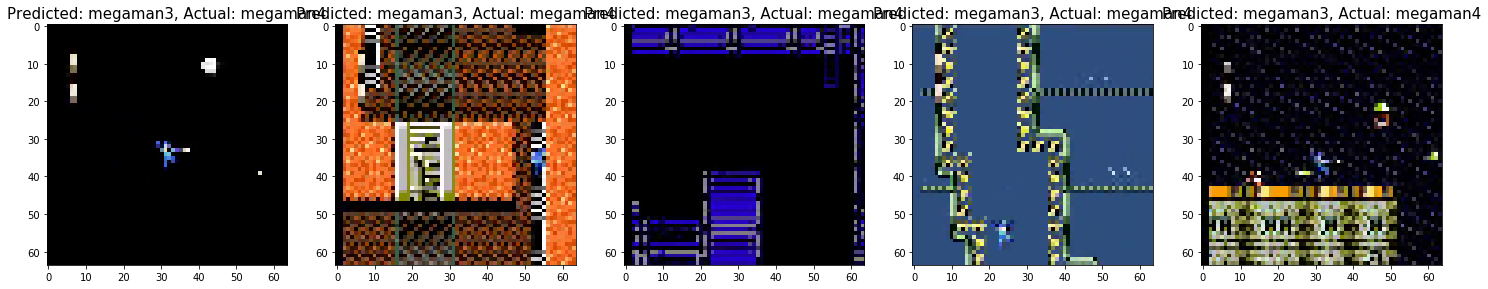

In [39]:
plt.figure(figsize=(25,5))
shuffle(misclassified_indices)
for plot_index, bad_index in enumerate(misclassified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    plt.imshow(X_eval[bad_index])
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[cnn_pred[bad_index][0]], 
                                                 labels_index[y_eval[bad_index]]), fontsize = 15)

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


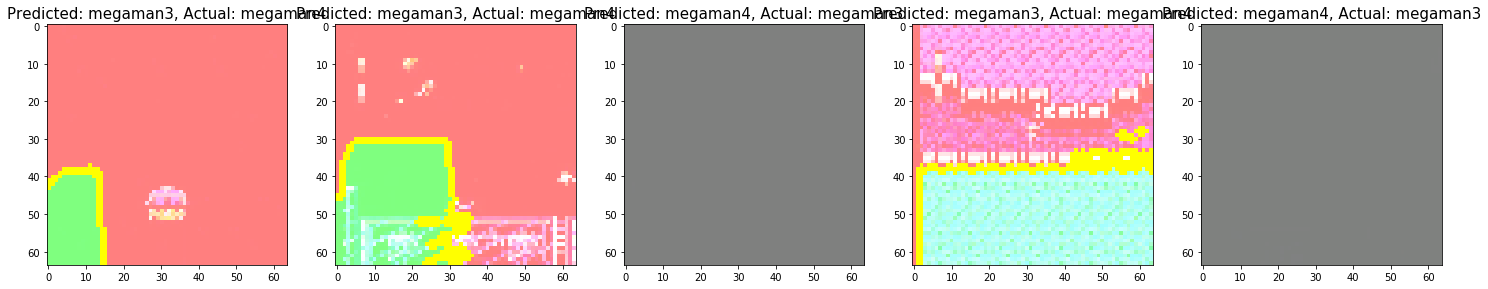

In [40]:
plt.figure(figsize=(25,5))
shuffle(misclassified_indices)
for plot_index, bad_index in enumerate(misclassified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(X_eval[bad_index], cnn_classifier.predict_classes, top_labels=2, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=10, hide_rest=False)
    x = mark_boundaries(temp / 2 + 0.5, mask)
    plt.imshow(x, interpolation='none')
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[cnn_pred[bad_index][0]], 
                                                 labels_index[y_eval[bad_index]]), fontsize = 15)